# Class Histogram Per Position Analysis - CIFAR Dataset

## Model

In [1]:
import numpy as np
import importlib
import random
import math
import json
import gc

import auxiliar_functions as af

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr

from matplotlib.colorbar import ColorbarBase

from keras.datasets import cifar10, mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import mode

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

num_classes = 10
y_train = np_utils.to_categorical(y_train, np.unique(y_train).shape[0])
y_test = np_utils.to_categorical(y_test, np.unique(y_test).shape[0])

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
model = load_model('saved_models/cifar10_ResNet20v1_model.126.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
p_labels = np.argmax(model.predict(x_train), axis=1) # Predicted labels for training set.
t_labels = np.argmax(y_train, axis=1) # True labels for training set.

scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.99%


# 1st Layer Analysis

In [6]:
h0, s0 = af.class_histogram_conv2d_v3(model, 3, x_train, t_labels, p_labels, num_classes)
gc.collect()
h0.shape, s0.shape

((16, 32, 32, 10), (16, 32, 32, 10))

In [7]:
h0border = np.array(h0)
h0 = h0[:, 1:-1, 1:-1, :]
h0.shape

(16, 30, 30, 10)

In [8]:
colors1 = cm.autumn(np.linspace(0., 1, 128))
colors2 = cm.cool(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mymap = clr.LinearSegmentedColormap.from_list('my_colormap', colors)

In [9]:
n_rows = h0.shape[0]
n_cols = h0.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Activation Occurrence Distribution of each Kernel (1st Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h0[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.00225, 0.025, 0.97325])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

In [10]:
clustering = AgglomerativeClustering(n_clusters=h0.shape[0], 
                                     compute_full_tree=True).fit(h0.reshape((16, 30*30*10)))

merge_order = clustering.children_
index_list = [[i] for i in range(h0.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

h0o = index_list[-1]
h0s = h0[h0o, :]
h0s.shape, len(h0o)

((16, 30, 30, 10), 16)

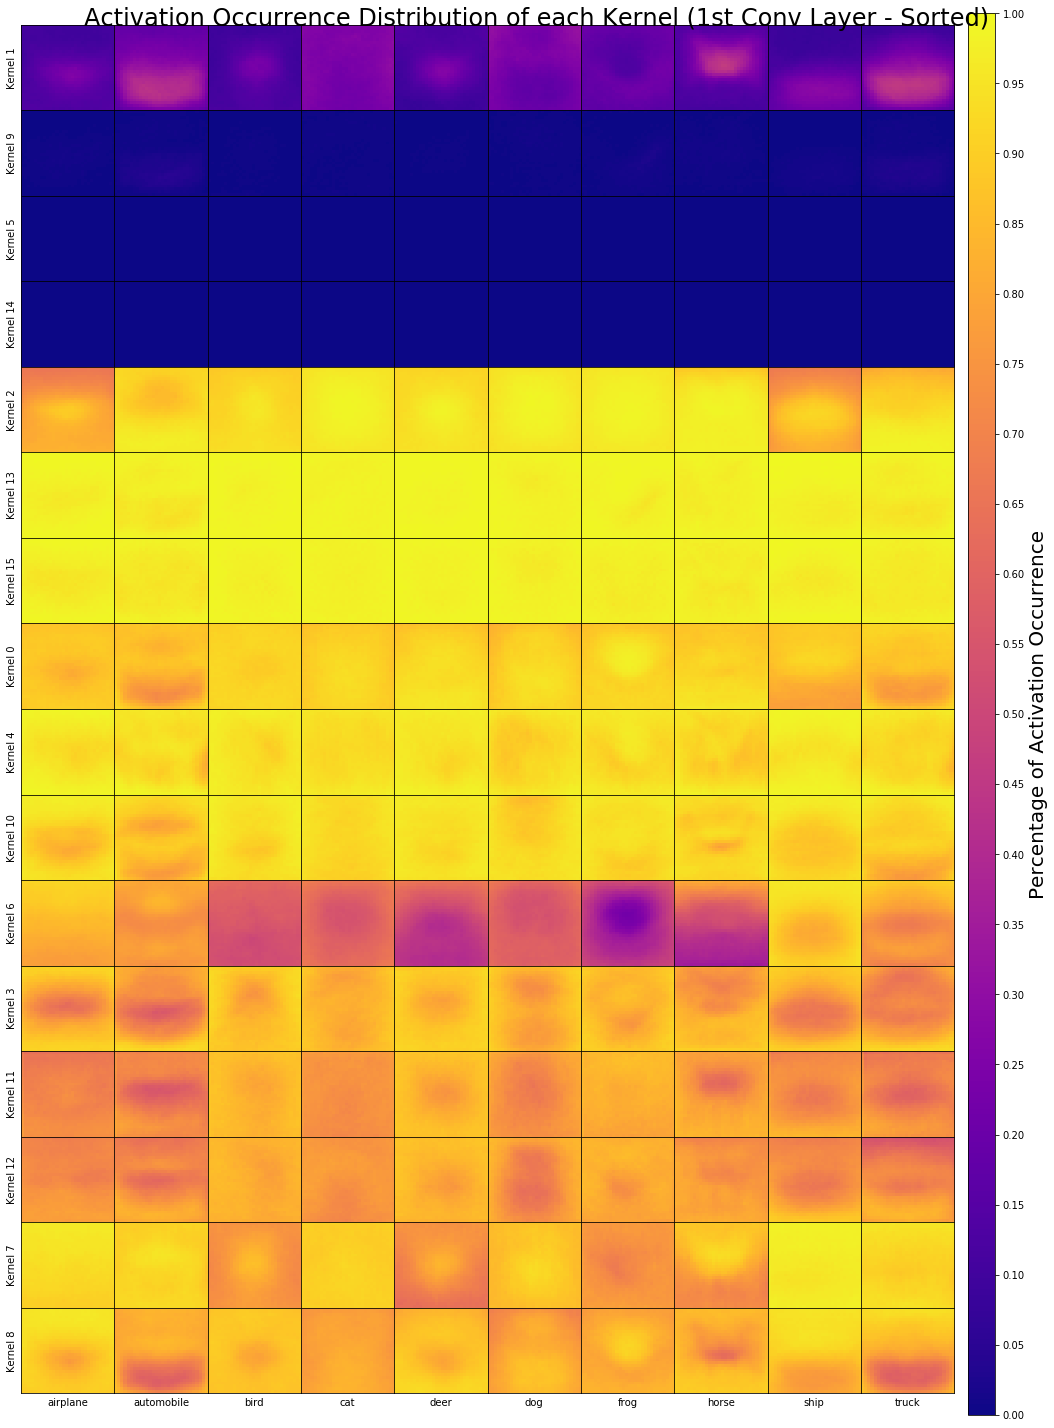

In [11]:
n_rows = h0s.shape[0]
n_cols = h0s.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Activation Occurrence Distribution of each Kernel (1st Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h0s[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(h0o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.00225, 0.025, 0.97325])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

## Position Selectivity

In [12]:
h0 = af.merge_pixels_dim(h0)
s0 = af.merge_pixels_dim(s0)
h0.shape, s0.shape

((16, 900, 10), (16, 1024, 10))

In [13]:
dch0 = af.position_class_selectivity(h0)
dcs0 = af.position_class_selectivity(s0)

dch0.shape, dcs0.shape

((16, 900, 10), (16, 1024, 10))

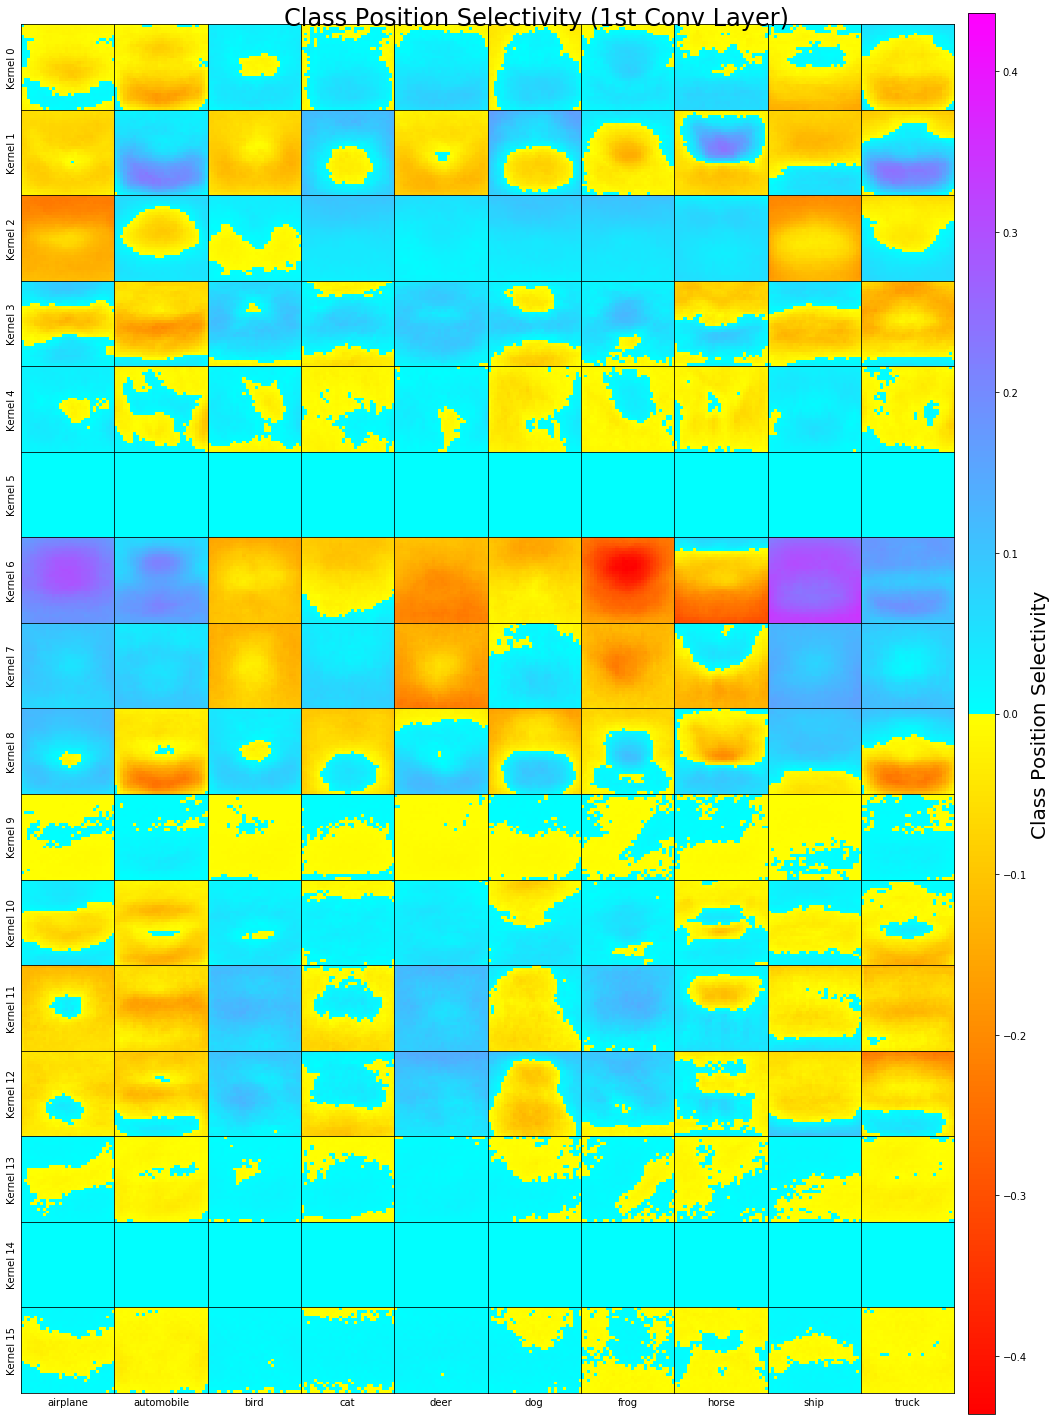

In [14]:
vlim = np.max(np.abs(dch0))

n_rows = dch0.shape[0]
n_cols = dch0.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Class Position Selectivity (1st Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(dch0[i, :, j].reshape((30, 30)), aspect='auto', cmap=mymap, 
                         vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.00225, 0.025, 0.97325])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

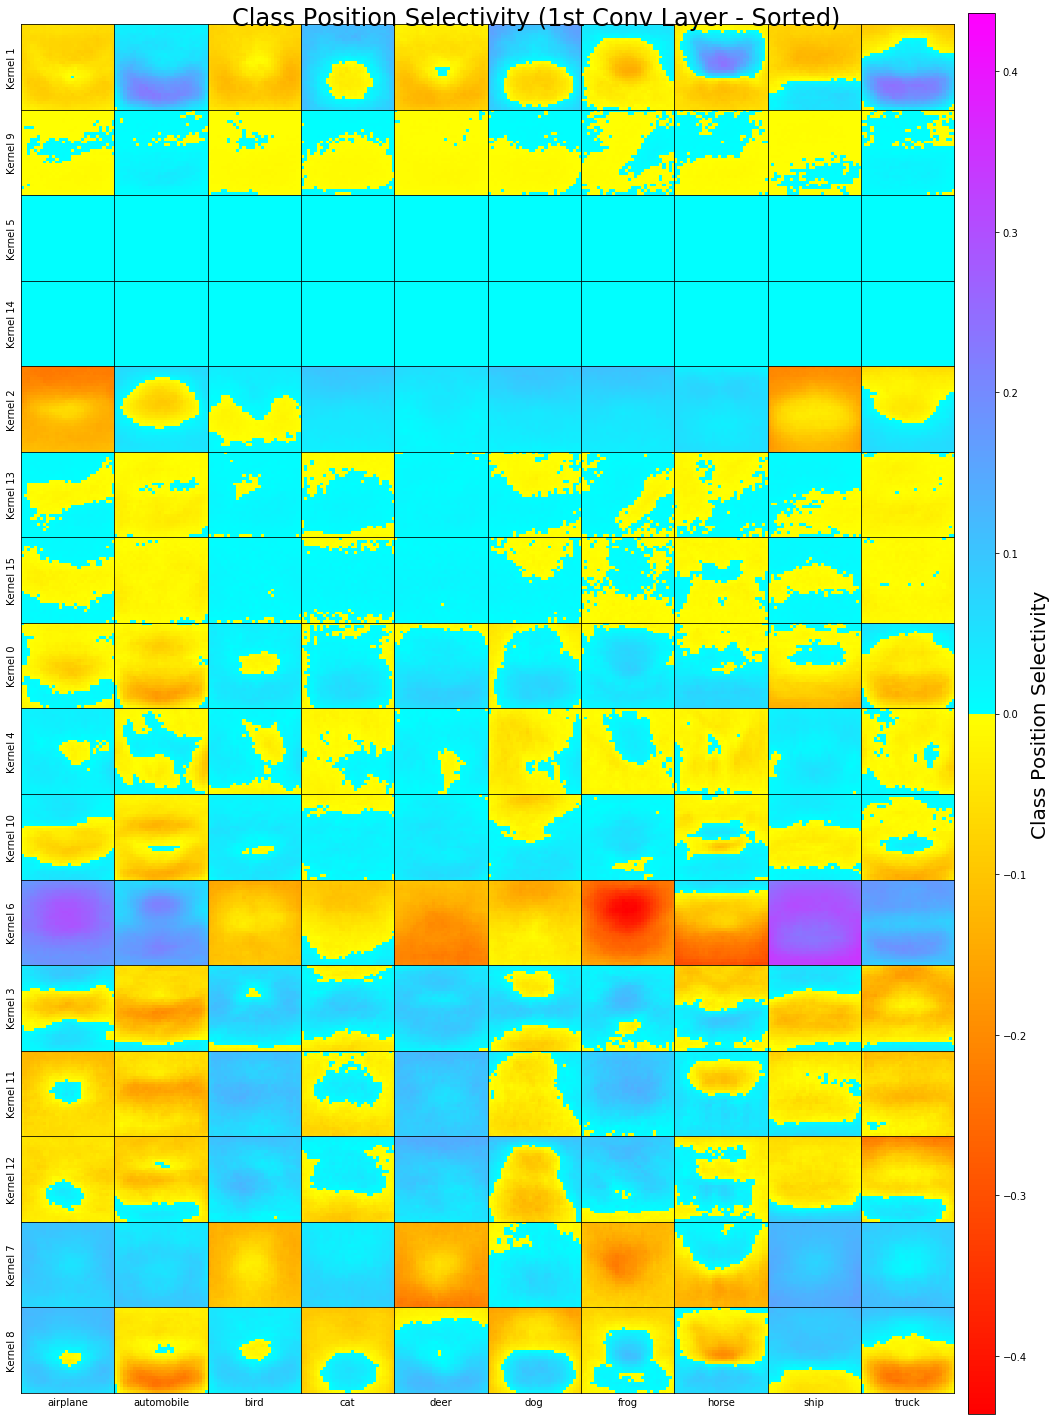

In [15]:
vlim = np.max(np.abs(dch0))

n_rows = dch0.shape[0]
n_cols = dch0.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Class Position Selectivity (1st Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(dch0[h0o[i], :, j].reshape((30,30)), aspect='auto', cmap=mymap, vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(h0o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.00225, 0.025, 0.97325])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

## Kernel Comparison

In [16]:
dm_sb = np.zeros((h0.shape[0], h0.shape[0]))

for k1 in range(h0.shape[0]):
    for k2 in range(h0.shape[0]):
        dm_sb[k1, k2] = np.mean(np.abs(h0[k1, :, :] - h0[k2, :, :]))

dm_sb.shape

(16, 16)

In [17]:
dm_sb_o = h0o
dm_sb_s = dm_sb[dm_sb_o, :]
dm_sb_s = dm_sb_s[:, dm_sb_o]

In [18]:
f, ax = plt.subplots(figsize=(15, 15))

im = ax.imshow(dm_sb_s, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(dm_sb_o))])
ax.set_xticklabels(dm_sb_o)

ax.set_yticks([i for i in range(len(dm_sb_o))])
ax.set_yticklabels(dm_sb_o)

ax.set_title('Kernels Difference Matrix (1st Conv Layer)', fontsize=20)

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.025, 0.025, 0.9225])
cbar = f.colorbar(im, cax=cbar_ax)
cbar.set_label('Average Activation Occurrence Difference', fontsize=20)

## Kernel Selectivity

In [19]:
dch0p = dch0
dch0p = np.mean(dch0p, axis=1)

ks_h0_sum = np.zeros((dch0p.shape[0],))

for k in range(dch0p.shape[0]):
    avg_l = []
    
    for i in range(dch0p.shape[1]):
        for j in range(i+1, dch0p.shape[1]):
            avg_l.append(dch0p[k, i] - dch0p[k, j])
        
    ks_h0_sum[k] = np.mean(np.abs(avg_l))

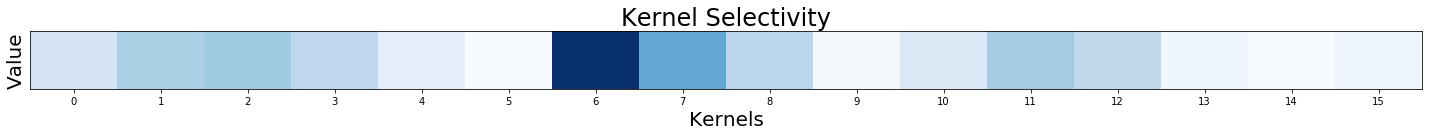

In [20]:
f, ax = plt.subplots(figsize=(20, 2))

ax.imshow(ks_h0_sum.reshape((ks_h0_sum.shape[0], 1)).T, aspect='auto', cmap=cm.Blues)

ax.set_xticks([i for i in range(len(ks_h0_sum))])
ax.set_yticks([])

ax.set_title('Kernel Selectivity', fontsize=24)
ax.set_xlabel('Kernels', fontsize=20)
ax.set_ylabel('Value', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

## Removal Experiments

In [ ]:
groups = [[63,12],[36],[44,2,45],[3],[62],[57],[5],[16,50,59],[42],[9],[29,31],[41,53,26,23,22,56,19,48,17],
          [46],[18,40,6,25],[13,55],[32,21,1,60],[35,15,38],[28],[14],[20,47],[4,11],[10,34,43],[7],[61,24,58],
          [52],[0],[37],[33,27],[54],[30,39],[51],[8],[49]]
len(groups)

In [ ]:
remains = []

for g in groups:
    sel = [ks_h0_sum[x] for x in g]
    chosen = np.argmax(sel)
    remains.append(g[chosen])

remains = np.array(remains)
    
print(len(remains), remains)

In [ ]:
n_model = af.reduce_model_units(model, 0, remains)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
remains_sel = ks_h0_sum[remains] # selectivity of each kernel
remains_ord = np.argsort(remains_sel)[::-1] # sort selectivity from max to min

remains1 = remains[remains_ord] # reorder kernels by selectivity order
remains1_sel = remains_sel[remains_ord] # reoder selectivity by selectivity order

remains2 = remains1[:-13] # drop.

remains2.shape[0]

In [ ]:
n_model = af.reduce_model_units(model, 0, remains2)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# avg_score = 0.0
# t = 20

# for _ in range(t):
#     remains_rand = np.array(random.sample(range(64), 20))
#     n_model = af.reduce_model_units(model, 0, remains_rand)
    
#     scores = n_model.evaluate(x_test, y_test, verbose=2)
#     avg_score += scores[1]*100 / t
    
# print("Average Accuracy with Random Dropping: %.2f%%" % avg_score) # 44.52%

In [ ]:
importlib.reload(af)
model2 = af.reduce_model_units(model, 0, remains2)
model2.summary()

In [ ]:
scores = model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
h = model2.fit(x_train, y_train, batch_size=32, epochs=1, verbose=1, validation_split=0.1, shuffle=True)

In [ ]:
p_labels = np.argmax(model2.predict(x_train), axis=1) # Predicted labels for training set.
t_labels = np.argmax(y_train, axis=1) # True labels for training set.

scores = model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
model2.save('models/cifar2l_6c_v2.h5')

# 6th Layer Analysis

In [21]:
importlib.reload(af)
h1, _ = af.class_histogram_conv2d_v4(model, -4, x_train, t_labels, p_labels, num_classes)
gc.collect()
h1.shape

(64, 8, 8, 10)

In [22]:
h1border = np.array(h1)
h1 = h1[:, 1:-1, 1:-1, :]
h1.shape

(64, 6, 6, 10)

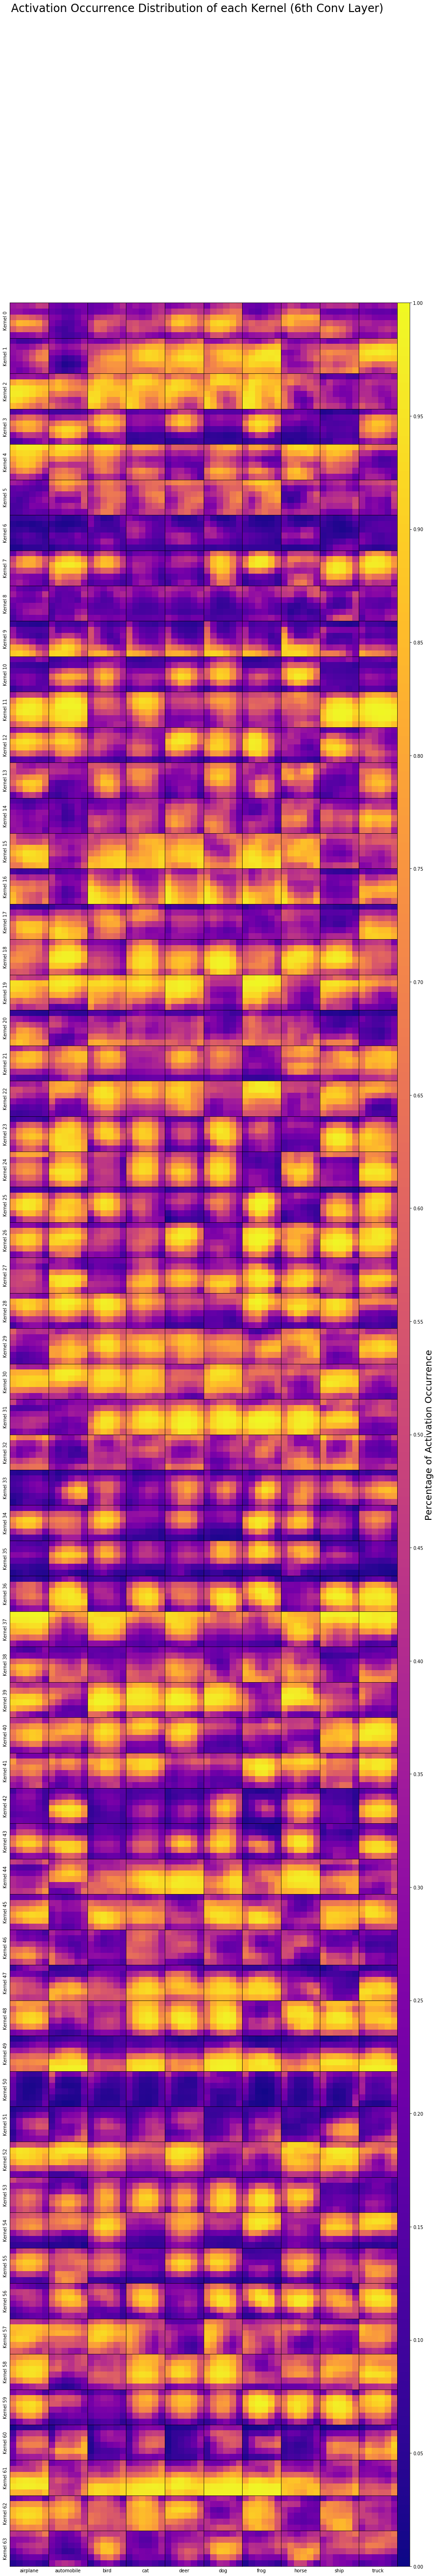

In [33]:
n_rows = h1.shape[0]
n_cols = h1.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 90))

f.suptitle('Activation Occurrence Distribution of each Kernel (6th Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h1[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

# f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.125, 0.025, 0.755])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

In [34]:
clustering = AgglomerativeClustering(n_clusters=h1.shape[0], 
                                     compute_full_tree=True).fit(h1.reshape((64, 6*6*10)))

merge_order = clustering.children_
index_list = [[i] for i in range(h1.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

h1o = index_list[-1]
h1s = h1[h1o, :]
h1s.shape, len(h1o)

((64, 6, 6, 10), 64)

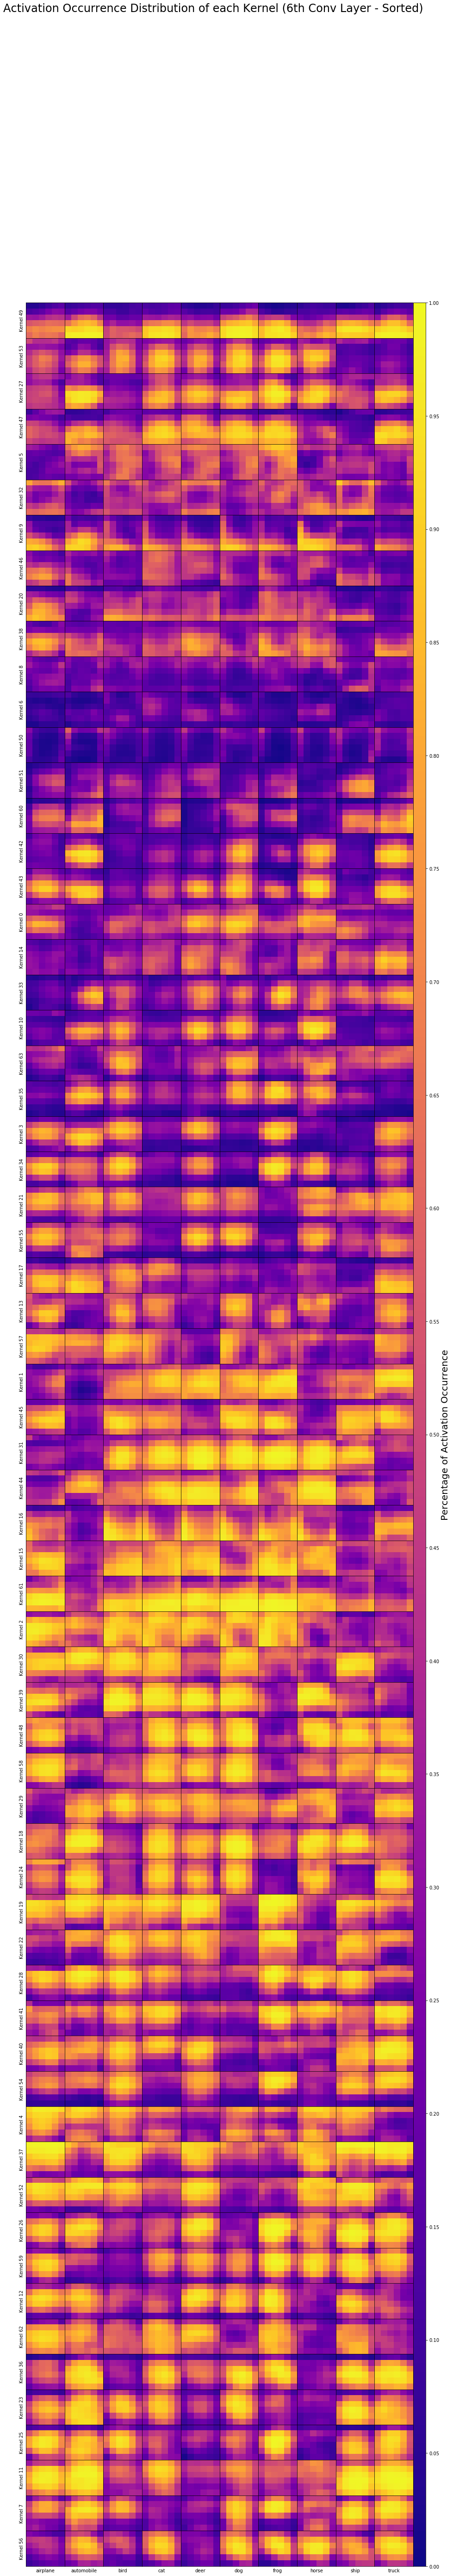

In [35]:
n_rows = h1s.shape[0]
n_cols = h1s.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 90))

f.suptitle('Activation Occurrence Distribution of each Kernel (6th Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h1s[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(h1o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

# f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.125, 0.025, 0.755])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

## Position Selectivity

In [36]:
h1 = af.merge_pixels_dim(h1)
h1.shape

(64, 36, 10)

In [37]:
dch1 = af.position_class_selectivity(h1)
dch1.shape

(64, 36, 10)

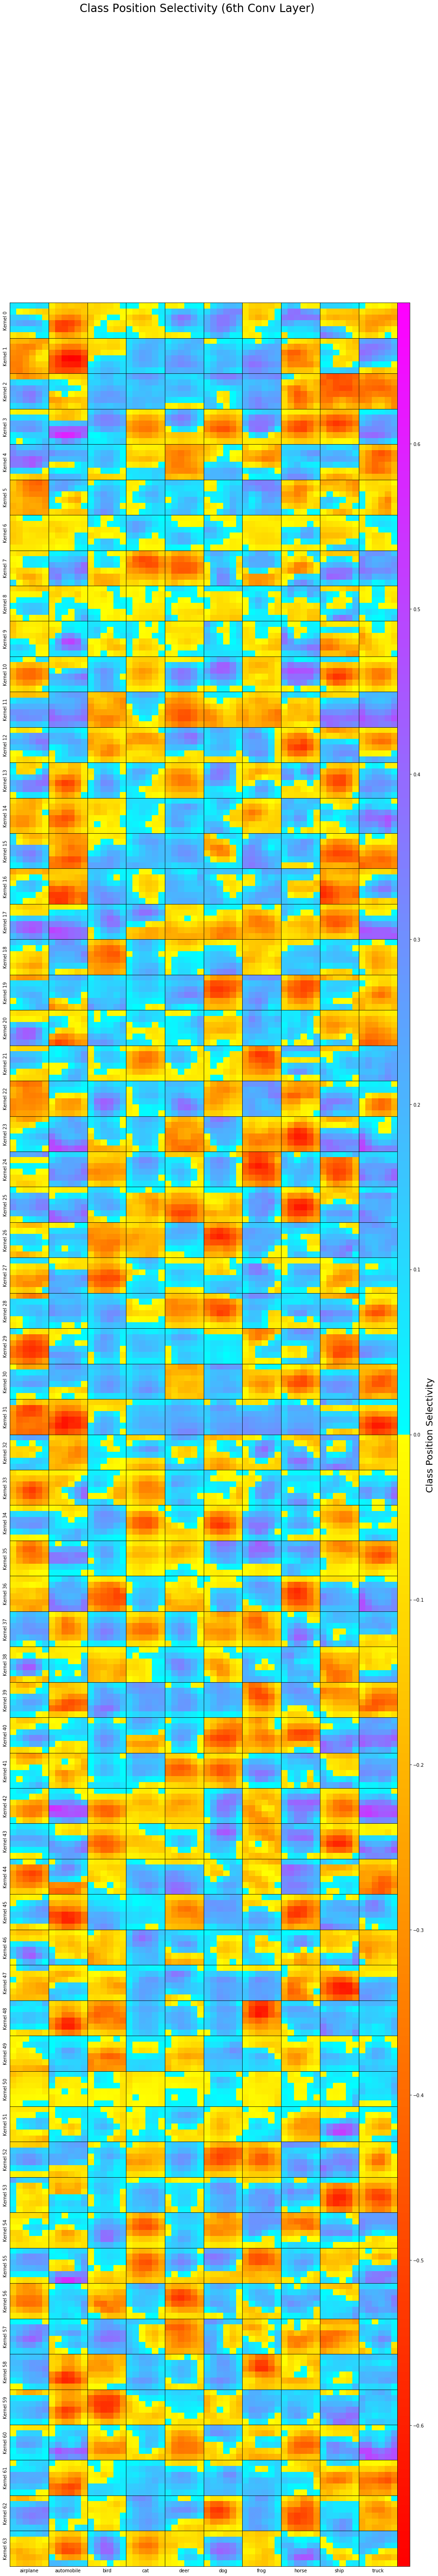

In [38]:
vlim = np.max(np.abs(dch1))

n_rows = dch1.shape[0]
n_cols = dch1.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 90))

f.suptitle('Class Position Selectivity (6th Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(dch1[i, :, j].reshape((6, 6)), aspect='auto', cmap=mymap, 
                         vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

# f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.125, 0.025, 0.755])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

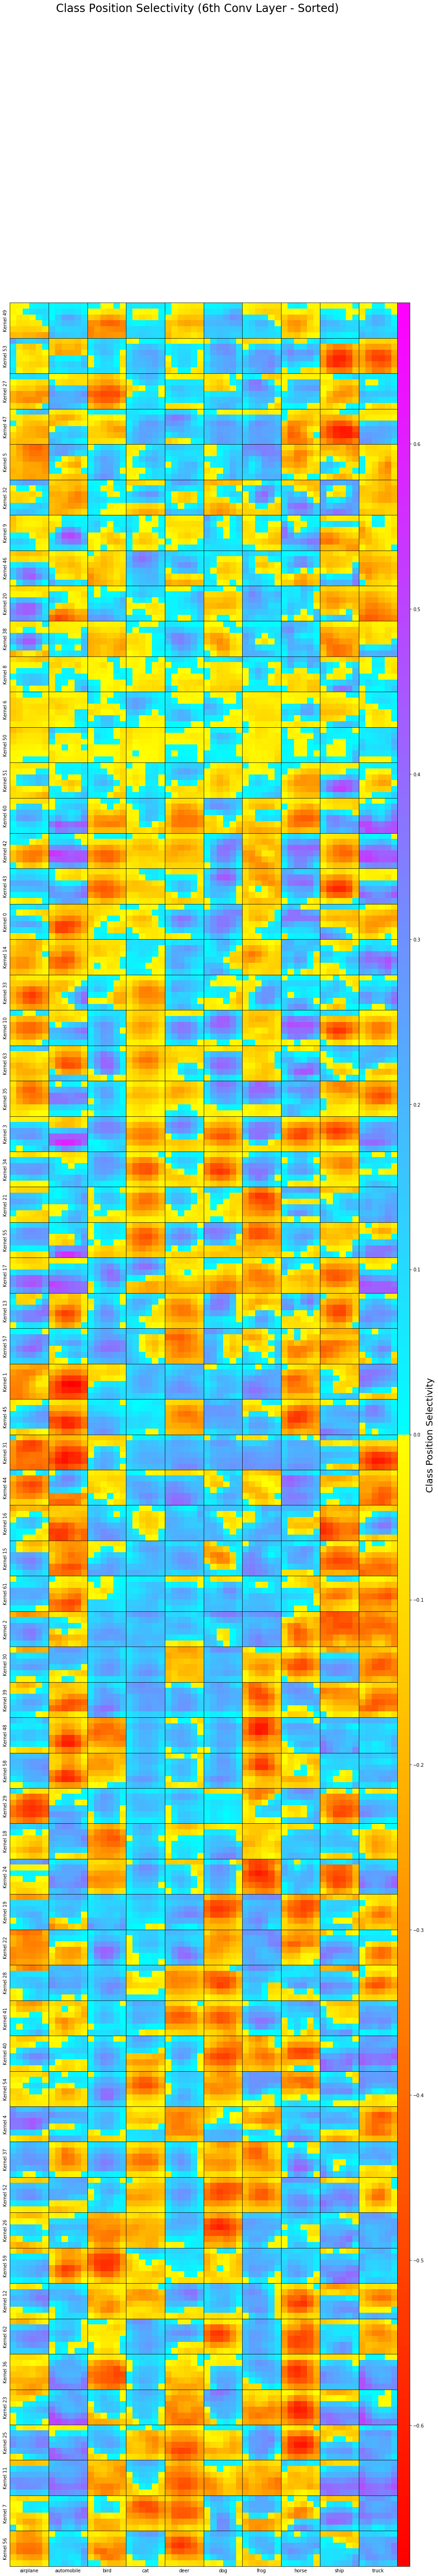

In [39]:
vlim = np.max(np.abs(dch1))

n_rows = dch1.shape[0]
n_cols = dch1.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 90))

f.suptitle('Class Position Selectivity (6th Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(dch1[h1o[i], :, j].reshape((6, 6)), aspect='auto', cmap=mymap, 
                         vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(h1o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

# f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.125, 0.025, 0.755])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

## Kernel Comparison

In [40]:
dm_sb = np.zeros((h1.shape[0], h1.shape[0]))

for k1 in range(h1.shape[0]):
    for k2 in range(h1.shape[0]):
        dm_sb[k1, k2] = np.mean(np.abs(h1[k1, :, :] - h1[k2, :, :]))

dm_sb.shape

(64, 64)

In [41]:
dm_sb_o = h1o
dm_sb_s = dm_sb[dm_sb_o, :]
dm_sb_s = dm_sb_s[:, dm_sb_o]

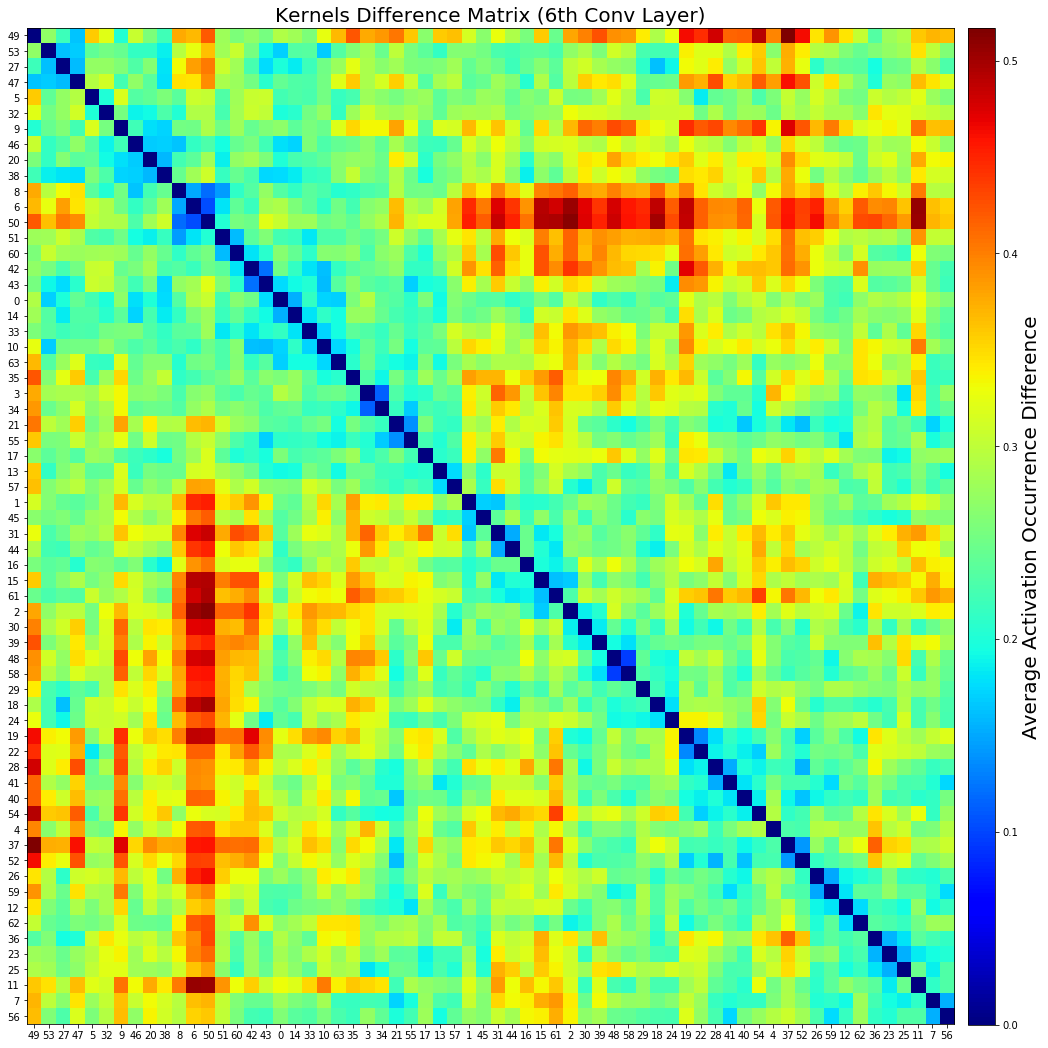

In [42]:
f, ax = plt.subplots(figsize=(15, 15))

im = ax.imshow(dm_sb_s, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(dm_sb_o))])
ax.set_xticklabels(dm_sb_o)

ax.set_yticks([i for i in range(len(dm_sb_o))])
ax.set_yticklabels(dm_sb_o)

ax.set_title('Kernels Difference Matrix (6th Conv Layer)', fontsize=20)

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.025, 0.025, 0.9225])
cbar = f.colorbar(im, cax=cbar_ax)
cbar.set_label('Average Activation Occurrence Difference', fontsize=20)

## Kernel Selectivity

In [43]:
dch1p = dch1
dch1p = np.mean(dch1p, axis=1)

ks_h1_sum = np.zeros((dch1p.shape[0],))

for k in range(dch1p.shape[0]):
    avg_l = []
    
    for i in range(dch1p.shape[1]):
        for j in range(i+1, dch1p.shape[1]):
            avg_l.append(dch1p[k, i] - dch1p[k, j])
        
    ks_h1_sum[k] = np.mean(np.abs(avg_l))

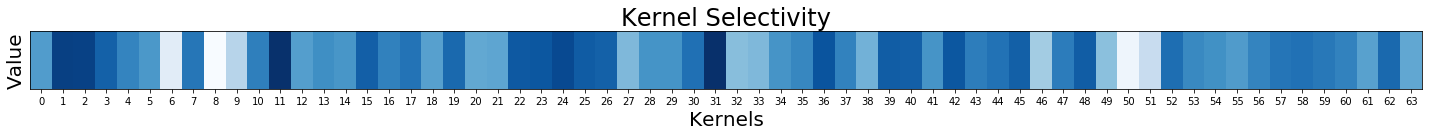

In [44]:
f, ax = plt.subplots(figsize=(20, 2))

ax.imshow(ks_h1_sum.reshape((ks_h1_sum.shape[0], 1)).T, aspect='auto', cmap=cm.Blues)

ax.set_xticks([i for i in range(len(ks_h1_sum))])
ax.set_yticks([])

ax.set_title('Kernel Selectivity', fontsize=24)
ax.set_xlabel('Kernels', fontsize=20)
ax.set_ylabel('Value', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

## Removal Experiments

In [ ]:
groups = [[49,21,60],[22],[48],[51,10],[16],[36,44],[13],[37],[35],[38,39],[9],[2],[18,20],[8],[32],[26],[45],
          [54,7],[3,25],[58],[63],[59,0,29],[31],[53],[42,4,15],[6],[33],[1],[11],[14],[24,50],[19],[56],
          [46,17],[43],[27],[23],[5,62],[47],[61],[40],[28],[41],[34],[52,55],[30],[12],[57]]

len(groups)

In [ ]:
# np.sort(np.array([x for g in groups for x in g])) == [i for i in range(64)]

In [ ]:
remains = []

for g in groups:
    sel = [ks_h1_sum[x] for x in g]
    chosen = np.argmax(sel)
    remains.append(g[chosen])

remains = np.array(remains)
    
print(len(remains), remains)

In [ ]:
n_model = af.reduce_model_units(model2, 9, remains)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
remains_sel = ks_h1_sum[remains] # selectivity of each kernel
remains_ord = np.argsort(remains_sel)[::-1] # sort selectivity from max to min

remains1 = remains[remains_ord] # reorder kernels by selectivity order
remains1_sel = remains_sel[remains_ord] # reoder selectivity by selectivity order

remains2 = remains1[:-13] # drop.

remains2.shape[0], remains2

In [ ]:
n_model = af.reduce_model_units(model2, 9, remains2)
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# avg_score = 0.0
# t = 20

# for _ in range(t):
#     remains_rand = np.array(random.sample(range(64), 30))
#     n_model = af.reduce_model_units(model6, 9, remains_rand)
    
#     scores = n_model.evaluate(x_test, y_test, verbose=2)
#     avg_score += scores[1]*100 / t
    
# print("Average Accuracy with Random Dropping: %.2f%%" % avg_score) # 59.44%

In [ ]:
importlib.reload(af)
model7 = af.reduce_model_units(model2, 9, remains2)
model7.summary()

In [ ]:
scores = model7.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
h = model7.fit(x_train, y_train, batch_size=32, epochs=1, verbose=1, validation_split=0.1, shuffle=True)

In [ ]:
p_labels = np.argmax(model7.predict(x_train), axis=1) # Predicted labels for training set.
t_labels = np.argmax(y_train, axis=1) # True labels for training set.

scores = model7.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
model7.save('models/cifar2l_6c_v7.h5')